# Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). We also use `z_3 = tf.floor(z_3)`. Surrogate gradients with one step is used. (one sided)

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is approximated with a surrogate. (See section 6)
* It also takes care of catastrophic forgetting by using synaptic intelligence.
* He initialization without AR1 gives lesser final accuracy than Trunc init because in He the gradients don't suffer from dimnishing.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)
   

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import DATA_Loader
import seaborn as sb
import theano, random, sys, time
from sklearn.utils import shuffle

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

# Hide code

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Plots
* FOR PRETTY IEEE PLOTS mpl.rcParams['figure.figsize'] = 4.5,2.5, all fonts 9-12

## Large

In [3]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25
mpl.rcParams['font.size'] = 22

## Small

In [4]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 4.5,2.75
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# Effect of $\lambda$s

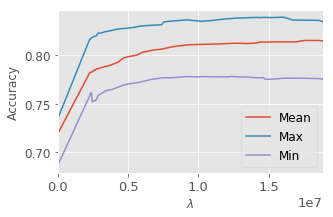

In [2]:
prev_final_test_acc1 = pd.read_csv('spike_sh_14lmbdas_ar1_3lyrs_he1_75_10_non_spk_classify.csv', 
                                  index_col=0)
prev_acc_grouped_by_lmbda1 = prev_final_test_acc1.groupby('lambdas')
prev_final_acc_grouped_by_lmbda1 = prev_acc_grouped_by_lmbda1.mean()
prev_final_acc_grouped_by_lmbda1.rename(columns={'Method3':'Mean'}, inplace=True)
prev_final_acc_grouped_by_lmbda1['S.D'] = prev_acc_grouped_by_lmbda1.std()
prev_final_acc_grouped_by_lmbda1['Min'] = prev_acc_grouped_by_lmbda1.min()
prev_final_acc_grouped_by_lmbda1['Max'] = prev_acc_grouped_by_lmbda1.max()
prev_final_acc_grouped_by_lmbda1['MED'] = prev_acc_grouped_by_lmbda1.median()
prev_final_acc_grouped_by_lmbda1.reset_index(inplace=True)
#display(prev_final_acc_grouped_by_lmbda1)
prev_final_test_acc2 = pd.read_csv('spike_sh_14lmbdas_ar1_3lyrs_he1_10_20_non_spk_classify.csv', 
                                  index_col=0)
prev_acc_grouped_by_lmbda2 = prev_final_test_acc2.groupby('lambdas')
prev_final_acc_grouped_by_lmbda2 = prev_acc_grouped_by_lmbda2.mean()
prev_final_acc_grouped_by_lmbda2.rename(columns={'Method3':'Mean'}, inplace=True)
prev_final_acc_grouped_by_lmbda2['S.D'] = prev_acc_grouped_by_lmbda2.std()
prev_final_acc_grouped_by_lmbda2['Min'] = prev_acc_grouped_by_lmbda2.min()
prev_final_acc_grouped_by_lmbda2['Max'] = prev_acc_grouped_by_lmbda2.max()
prev_final_acc_grouped_by_lmbda2['MED'] = prev_acc_grouped_by_lmbda2.median()
prev_final_acc_grouped_by_lmbda2.reset_index(inplace=True)
#display(prev_final_acc_grouped_by_lmbda2)
prev_final_test_acc3 = pd.read_csv('spike_sh_14lmbdas_ar1_3lyrs_he1_20_45_non_spk_classify.csv', 
                                  index_col=0)
prev_acc_grouped_by_lmbda3 = prev_final_test_acc3.groupby('lambdas')
prev_final_acc_grouped_by_lmbda3 = prev_acc_grouped_by_lmbda3.mean()
prev_final_acc_grouped_by_lmbda3.rename(columns={'Method3':'Mean'}, inplace=True)
prev_final_acc_grouped_by_lmbda3['S.D'] = prev_acc_grouped_by_lmbda3.std()
prev_final_acc_grouped_by_lmbda3['Min'] = prev_acc_grouped_by_lmbda3.min()
prev_final_acc_grouped_by_lmbda3['Max'] = prev_acc_grouped_by_lmbda3.max()
prev_final_acc_grouped_by_lmbda3['MED'] = prev_acc_grouped_by_lmbda3.median()
prev_final_acc_grouped_by_lmbda3.reset_index(inplace=True)
#display(prev_final_acc_grouped_by_lmbda3)
prev_final_test_acc4 = pd.read_csv('spike_sh_14lmbdas_ar1_3lyrs_he1_45_65_non_spk_classify.csv', 
                                  index_col=0)
prev_acc_grouped_by_lmbda4 = prev_final_test_acc4.groupby('lambdas')
prev_final_acc_grouped_by_lmbda4 = prev_acc_grouped_by_lmbda4.mean()
prev_final_acc_grouped_by_lmbda4.rename(columns={'Method3':'Mean'}, inplace=True)
prev_final_acc_grouped_by_lmbda4['S.D'] = prev_acc_grouped_by_lmbda4.std()
prev_final_acc_grouped_by_lmbda4['Min'] = prev_acc_grouped_by_lmbda4.min()
prev_final_acc_grouped_by_lmbda4['Max'] = prev_acc_grouped_by_lmbda4.max()
prev_final_acc_grouped_by_lmbda4['MED'] = prev_acc_grouped_by_lmbda4.median()
prev_final_acc_grouped_by_lmbda4.reset_index(inplace=True)
#display(prev_final_acc_grouped_by_lmbda4)
df4 = prev_final_acc_grouped_by_lmbda4.copy(deep=True)
#df4.drop([0], inplace=True)

df3 = prev_final_acc_grouped_by_lmbda3.copy(deep=True)
#df3.drop([0], inplace=True)

df2 = prev_final_acc_grouped_by_lmbda2.copy(deep=True)
df2.drop([0], inplace=True)

df1 = prev_final_acc_grouped_by_lmbda1.copy(deep=True)
#df1.drop([0], inplace=True)

final_df = pd.concat([df1, df2, df3, df4], axis=0)
final_df.reset_index(inplace=True, drop=True)
final_df['lambdas']=final_df['lambdas']*30 ##saved wrongly scaled lambdas, so re-scale them
#display(final_df)
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax=final_df.plot(y=['Mean','Max', 'Min'],x='lambdas')
#ax=final_df.plot(y=['Mean'],x='lambdas')
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
ax.set_xlabel('$\lambda$')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig('../outputs/tg_mnist_results_cl/lambda_vs_acc2.pdf', bbox_inches='tight')
plt.savefig('../outputs/tg_mnist_results_cl/lambda_vs_acc2.png', bbox_inches='tight')
plt.savefig('../outputs/tg_mnist_results_cl/lambda_vs_acc2.eps', bbox_inches='tight')
plt.show()

# Load data

In [5]:
filename = '../../spiking_networks/train_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.float32)
#@@emnist_train_images[np.where(emnist_train_images>=1)] = 1

filehandle = open('../../spiking_networks/train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.float32).tolist()
filehandle.close()
emnist_train_labels = np.array(emnist_train_labels)
print('Total train features:{}'.format(emnist_train_images.shape[0]))

#### LOAD TEST IMAGES AND LABELS
filename = '../../spiking_networks/test_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.float32)
#@@emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('Total test features:{}'.format(emnist_test_images.shape[0]))

filehandle = open('../../spiking_networks/test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.float32)
filehandle.close()
emnist_test_labels = np.array(emnist_test_labels)

#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = emnist_train_images
train_labels = emnist_train_labels
train_labels = np.array(train_labels)
test_images = emnist_test_images
test_labels = emnist_test_labels
num_classes=10

Total train features:60000
Total test features:10000


In [6]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [7]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

# Start a session

In [8]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

# Setup the network

In [9]:
n_input = 3630
n_middle = 1500
n_out = 10
batch_size = tf.placeholder(tf.int64, name='batch_size') 
gradient_gate = tf.placeholder(tf.float32, name='gradient_gate') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [10], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2')
    w_2_update_op = w_2.assign(w_2_update_placeholder)
    tf.summary.histogram('w_2', w_2)
    
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    b_2_update_placeholder = tf.placeholder(b_2.dtype, shape=b_2.get_shape(),name='update_b2')
    b_2_update_op = b_2.assign(b_2_update_placeholder)
    tf.summary.histogram('b_2', b_2)
    
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32),name='w2_grad_accum')
    w2_grad_accum_update_placeholder=tf.placeholder(w2_grad_accum.dtype, shape=w2_grad_accum.get_shape(),
                                            name='update_w2_grad_accum')
    w2_grad_accum_update_op = w2_grad_accum.assign(w2_grad_accum_update_placeholder)
    
    
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    b2_grad_accum_update_placeholder=tf.placeholder(b2_grad_accum.dtype,shape=b2_grad_accum.get_shape(),
                                            name='update_b2_grad_accum')
    b2_grad_accum_update_op = b2_grad_accum.assign(b2_grad_accum_update_placeholder)
    
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_w2_update_placeholder = tf.placeholder(big_omeg_w2.dtype, shape=big_omeg_w2.get_shape(),
                                                    name='update_big_omeg_w2')
    big_omeg_w2_update_op = big_omeg_w2.assign(big_omeg_w2_update_placeholder)
    
    
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    big_omeg_b2_update_placeholder = tf.placeholder(big_omeg_b2.dtype, shape=big_omeg_b2.get_shape(),
                                                    name='update_big_omeg_b2')
    big_omeg_b2_update_op = big_omeg_b2.assign(big_omeg_b2_update_placeholder)
    
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_w2_update_placeholder = tf.placeholder(star_w2.dtype, shape=star_w2.get_shape(),
                                                name='update_star_w2')
    star_w2_update_op = star_w2.assign(star_w2_update_placeholder)
    
    
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
    star_b2_update_placeholder = tf.placeholder(star_b2.dtype, shape=star_b2.get_shape(),
                                                name='update_star_b2')
    star_b2_update_op = star_b2.assign(star_b2_update_placeholder)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    w_3_update_placeholder = tf.placeholder(w_3.dtype, shape=w_3.get_shape(),name='update_w3')
    w_3_update_op = w_3.assign(w_3_update_placeholder)
    
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    b_3_update_placeholder = tf.placeholder(b_3.dtype, shape=b_3.get_shape(),name='update_b3')
    b_3_update_op = b_3.assign(b_3_update_placeholder)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    #@@a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    #@@z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
                        name = 'delta2')
    #@@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2),
    #@@                    name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    d_b_2 = tf.multiply(gradient_gate, d_b_2, name='gradient_gating_b2')
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    d_w_2 = tf.multiply(gradient_gate, d_w_2, name='gradient_gating_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]
with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)
    
    #test_accuracy_summary = tf.summary.scalar('test_accuracy', acct_res)
    
init_op = tf.global_variables_initializer()

# Init the writer with three best $\lambda$s

In [14]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_mnist_ar1_final', sess.graph)

# Generate $\lambda$s

In [15]:
np.random.seed(100)
n_lmbdas = 6
a = np.random.uniform(low=111.0, high=220, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e5
a = a[np.argsort(a)]
a= a[-3:]
print(a)a
print()
n_reps = 10
#a = ([0]+a.tolist())*n_reps
#n_lmbdas+=1
a = a.tolist()*n_reps
print(a, len(a))

[170.23113866 141.34226298 157.27241739 203.08059842 111.51435532
 124.25103417]
()
[15727241.73916555 17023113.86552152 20308059.84228695]
()
([15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695, 15727241.73916555, 17023113.865521524, 20308059.84228695], 30)


# Generate random weights

In [16]:
lmbdas = a
np.random.seed(0)
np_weights = []
n_lmbdas = 3
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(30, 30)


In [17]:
np.array_equal(np_weights[0], np_weights[2])

True

In [18]:
np.array_equal(np_weights[0], np_weights[3])

False

# Commence training

In [19]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
all_prev_task_test_accs = []
all_prev_task_test_activs = []
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    frac_old_train_images = []
    frac_old_train_labels = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    prev_task_test_accs = []
    prev_task_test_activs = []
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==epochs-1):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            if(i==epochs-1):   
                                summary,_,_ = sess.run([merged,step, omega_step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total})
                            else:
                                summary,_, = sess.run([merged,step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            if(i==epochs-1):
                                sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                         tau:0.5,set1_mask:set_mask_val,
                                                                         eta:0.001,lmbda:lmbdas[l],
                                                                         n_tot:train_total})
                            else:
                                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
        
        old_test_data.append(test_data_set)
        #######Method 3 ###########
        w3_set_rows = []
        offset=0
        for item in w3_accum:
            w3_set_rows.append(item[:,offset:offset+2])
            offset+=2


        w3_set_row_avgs = [item.mean() for item in w3_set_rows]
        final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
        #final_w3 = np.concatenate(final_w3, axis=1)
        final_w3 = np.concatenate([item for item in final_w3]+[np.zeros((1500,10-offset))], axis=1)
        
        b3_set_rows = []
        offset=0
        for item in b3_accum:
            b3_set_rows.append(item[:,offset:offset+2])
            offset+=2
        b3_set_row_avgs = [item.mean() for item in b3_set_rows]
        final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
        #final_b3 = np.concatenate(final_b3, axis=1)
        final_b3 = np.concatenate([item for item in final_b3]+[np.zeros((1,10-offset))], axis=1)
        
        #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
        #@@sess.run(set_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
        sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs.append(final_test_acc)
            prev_task_test_activs.append(final_test_activ)
            print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    all_prev_task_test_accs.append(prev_task_test_accs)
    all_prev_task_test_activs.append(prev_task_test_activs)
    
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:15727241.7392, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.179362744093 and training accuracy:0.997657477856
validation cost:0.177786141634 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0546306855977 and training accuracy:0.998178005219
validation cost:0.0556919276714 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0317249856889 and training accuracy:0.998611807823
validation cost:0.0331957191229 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0226408895105 and training accuracy:0.998785376549
validation cost:0.0242020450532 and validation a

Training on :(8, 9)
training cost:0.106157198548 and training accuracy:0.974110662937
validation cost:0.107667319477 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.094076320529 and training accuracy:0.977090716362
validation cost:0.0954104885459 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0853007212281 and training accuracy:0.978860139847
validation cost:0.0864376649261 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0785308629274 and training accuracy:0.980815768242
validation cost:0.0794739723206 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.073092199862 and training accuracy:0.982585191727
validation cost:0.073853969574 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0685961470008 and training accuracy:0.983795881271
validation cost:0.0691948980093 and validation accuracy:0.98681730032
Training on :(8, 9)
Time taken:174.674751043
Method 3 test 

Training on :(6, 7)
training cost:0.0278671365231 and training accuracy:0.999007821083
validation cost:0.0276022274047 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0254179630429 and training accuracy:0.999188244343
validation cost:0.0251827277243 and validation accuracy:1.0
Training on :(6, 7)
Time taken:181.405064106
Method 3 test accuracy:0.978723406792
Method 3 test accuracy:0.909892261028
Method 3 test accuracy:0.648879408836
Method 3 test accuracy:0.887210488319
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.25309073925 and training accuracy:0.959210276604
validation cost:0.253914475441 and validation accuracy:0.954802274704
Training on :(8, 9)


training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.193551510572 and training accuracy:0.991972565651
validation cost:0.188383430243 and validation accuracy:0.989051103592
Training on :(6, 7)
training cost:0.095094576478 and training accuracy:0.995670616627
validation cost:0.0930287018418 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0653166025877 and training accuracy:0.996662735939
validation cost:0.0642426237464 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0508543401957 and training accuracy:0.997294127941
validation cost:0.0502023473382 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0421987175941 and training accuracy:0.997745096684
validation cost:0.0417569167912 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0363784655929 and training accuracy:0.998105883598
validation cos

Training on :(4, 5)
training cost:0.0681548044086 and training accuracy:0.994926810265
validation cost:0.060954015702 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0558069013059 and training accuracy:0.995317101479
validation cost:0.048561822623 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0475746877491 and training accuracy:0.995707333088
validation cost:0.0404448546469 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0416698865592 and training accuracy:0.996195137501
validation cost:0.0347174964845 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.037211406976 and training accuracy:0.996682941914
validation cost:0.0304580740631 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0337132848799 and training accuracy:0.996780514717
validation cost:0.027163837105 and validation accuracy:1.0
Training on :(4, 5)
Time taken:131.590862036
Method 3 test accuracy:0.984397172928
Method 3 test accuracy:0.927522063255
M

Training on :(2, 3)
training cost:0.0566468574107 and training accuracy:0.985819458961
validation cost:0.0616080760956 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.051774173975 and training accuracy:0.98772841692
validation cost:0.056301843375 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:142.172040939
Method 3 test accuracy:0.986761212349
Method 3 test accuracy:0.931929469109
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.25743663311 and training accuracy:0.978926837444
validation cost:0.258555442095 and validation accuracy:0.984205305576
Training on :(4, 5)
training cost:0.13191318512 and training accuracy:0.98975610733

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.35212662816 and training accuracy:0.943368792534
validation cost:0.357444226742 and validation accuracy:0.945772051811
Training on :(2, 3)
training cost:0.177647516131 and training accuracy:0.96136713028
validation cost:0.183137059212 and validation accuracy:0.958639681339
Training on :(2, 3)
training cost:0.124100856483 and training accuracy:0.969820916653
validation cost:0.130347877741 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0978837013245 and training accuracy:0.975365877151
validation cost:0.104327149689 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0819756239653 and training accuracy:0.978820085526
validation cost:0.0882209613919 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0711326226592 and training accuracy:0.982183456421
validation cost:0.07

Training on :(0, 1)
training cost:0.0225540343672 and training accuracy:0.998698592186
validation cost:0.0237094499171 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0176254808903 and training accuracy:0.998785376549
validation cost:0.0187979545444 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0145592540503 and training accuracy:0.998785376549
validation cost:0.0157190151513 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.012457286939 and training accuracy:0.998872101307
validation cost:0.0135930338874 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0109200486913 and training accuracy:0.99895888567
validation cost:0.0120275393128 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0097421137616 and training accuracy:0.99895888567
validation cost:0.0108201066032 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:147.415590048
Method 3 t

Training on :(8, 9)
training cost:0.0703023448586 and training accuracy:0.983609616756
validation cost:0.0722124278545 and validation accuracy:0.98399245739
Training on :(8, 9)
Time taken:139.004817963
Method 3 test accuracy:0.707801401615
Method 3 test accuracy:0.914299726486
Method 3 test accuracy:0.62433296442
Method 3 test accuracy:0.925478339195
Method 3 test accuracy:0.72516387701
Training with lmbda:17023113.8655, 7
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.187413960695 and training accuracy:0.997744202614
validation cost:0.185390353203 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.055508248508 and training

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.255603343248 and training accuracy:0.955950856209
validation cost:0.256593793631 and validation accuracy:0.951977372169
Training on :(8, 9)
training cost:0.162157446146 and training accuracy:0.965077280998
validation cost:0.16389799118 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.128287032247 and training accuracy:0.970571815968
validation cost:0.130409166217 and validation accuracy:0.96798491478
Training on :(8, 9)
training cost:0.109670966864 and training accuracy:0.973831236362
validation cost:0.111932113767 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0973930805922 and training accuracy:0.976438820362
validation cost:0.099666915834 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0884562879801 and training accuracy:0.977835714817
validation cost:0.0906

Training on :(6, 7)
training cost:0.0485129095614 and training accuracy:0.997835278511
validation cost:0.0467637479305 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0404436141253 and training accuracy:0.997925519943
validation cost:0.0388954132795 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.034991774708 and training accuracy:0.998196065426
validation cost:0.0335683040321 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0310294236988 and training accuracy:0.998647093773
validation cost:0.0296899620444 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.027999650687 and training accuracy:0.998827457428
validation cost:0.0267201922834 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0255970638245 and training accuracy:0.998917639256
validation cost:0.0243630968034 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:142.53430295
Method 3 test 

Training on :(4, 5)
training cost:0.0371683426201 and training accuracy:0.996195137501
validation cost:0.0307877790183 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0337294973433 and training accuracy:0.996487796307
validation cost:0.0274976976216 and validation accuracy:1.0
Training on :(4, 5)
Time taken:132.157408953
Method 3 test accuracy:0.974468111992
Method 3 test accuracy:0.888834476471
Method 3 test accuracy:0.86125934124
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.180687367916 and training accuracy:0.992333352566
validation cost:0.175184339285 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0885862186551 and trai

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.256345063448 and training accuracy:0.980585336685
validation cost:0.258987039328 and validation accuracy:0.98617964983
Training on :(4, 5)
training cost:0.130676999688 and training accuracy:0.989853680134
validation cost:0.127095550299 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0888583958149 and training accuracy:0.993365824223
validation cost:0.0831955596805 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0682802796364 and training accuracy:0.994243919849
validation cost:0.0619091652334 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0560254752636 and training accuracy:0.995121955872
validation cost:0.0494434535503 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0478582121432 and training accuracy:0.995512187481
validation cost:0

Training on :(2, 3)
training cost:0.0967734754086 and training accuracy:0.976456701756
validation cost:0.101813696325 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0812279507518 and training accuracy:0.979183733463
validation cost:0.0861025229096 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0706099793315 and training accuracy:0.982456147671
validation cost:0.0751713588834 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.062818236649 and training accuracy:0.984728634357
validation cost:0.0670166760683 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0568092092872 and training accuracy:0.986728489399
validation cost:0.0606398172677 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0520026311278 and training accuracy:0.987819314003
validation cost:0.0554734617472 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:141.668229818
Method 3 test a

Training on :(0, 1)
training cost:0.0112824933603 and training accuracy:0.99895888567
validation cost:0.013022984378 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0100769754499 and training accuracy:0.99895888567
validation cost:0.0117728943005 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:148.593173027
Method 3 test accuracy:0.999054372311
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.343936920166 and training accuracy:0.940278172493
validation cost:0.348930180073 and validation accuracy:0.946691155434
Training on :(2, 3)
training cost:0.175957992673 and training accuracy:0.960367262363
validation cost:0.1801686286

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.185201182961 and training accuracy:0.997483968735
validation cost:0.183476597071 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0560917071998 and training accuracy:0.99809128046
validation cost:0.0573302432895 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0324285849929 and training accuracy:0.998264789581
validation cost:0.0341561622918 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0230844113976 and training accuracy:0.998351573944
validation cost:0.0249240230769 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0181016530842 and training accuracy:0.998525083065
validation cost:0.019950889051 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0149912079796 and training accuracy:0.998611

Training on :(8, 9)
training cost:0.0942561551929 and training accuracy:0.977090716362
validation cost:0.0941424369812 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0853682160378 and training accuracy:0.980070769787
validation cost:0.085158392787 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.078552596271 and training accuracy:0.981653928757
validation cost:0.0782314240932 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0731062814593 and training accuracy:0.982585191727
validation cost:0.072671033442 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0686202272773 and training accuracy:0.983237087727
validation cost:0.0680750533938 and validation accuracy:0.985875725746
Training on :(8, 9)
Time taken:137.638487816
Method 3 test accuracy:0.979196190834
Method 3 test accuracy:0.791870713234
Method 3 test accuracy:0.894343674183
Method 3 test accuracy:0.859516620636
Method 3 test ac

Training on :(6, 7)
training cost:0.0265895333141 and training accuracy:0.998647093773
validation cost:0.02606767416 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:142.496354103
Method 3 test accuracy:0.979196190834
Method 3 test accuracy:0.825661122799
Method 3 test accuracy:0.903948783875
Method 3 test accuracy:0.87210470438
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.262948513031 and training accuracy:0.960327804089
validation cost:0.262465059757 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.164376139641 and training accuracy:0.967777967453
validation cost:0.164112076163 and validation accuracy:0.967043340206
Tr

Training on :(6, 7)
training cost:0.184185177088 and training accuracy:0.991250991821
validation cost:0.177336379886 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0906633362174 and training accuracy:0.995129406452
validation cost:0.0869396179914 and validation accuracy:0.993613123894
Training on :(6, 7)
training cost:0.0624380633235 and training accuracy:0.996843159199
validation cost:0.0597147978842 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0487097203732 and training accuracy:0.997384309769
validation cost:0.0464183837175 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.040480684489 and training accuracy:0.997654914856
validation cost:0.0384185872972 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0349415466189 and training accuracy:0.997925519943
validation cost:0.0330181568861 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0309251770377 and trainin

Training on :(4, 5)
training cost:0.0550067424774 and training accuracy:0.995219528675
validation cost:0.0485085658729 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.047014515847 and training accuracy:0.995707333088
validation cost:0.0404792875051 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0412854105234 and training accuracy:0.996097564697
validation cost:0.0348101221025 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0369587168097 and training accuracy:0.996195137501
validation cost:0.0305889435112 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0335622802377 and training accuracy:0.996390223503
validation cost:0.0273206327111 and validation accuracy:1.0
Training on :(4, 5)
Time taken:132.176032066
Method 3 test accuracy:0.981087446213
Method 3 test accuracy:0.94074434042
Method 3 test accuracy:0.661152601242
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train fea

Training on :(2, 3)
training cost:0.0513269267976 and training accuracy:0.987182974815
validation cost:0.0552962608635 and validation accuracy:0.983455896378
Training on :(2, 3)
Time taken:141.800186157
Method 3 test accuracy:0.983924329281
Method 3 test accuracy:0.946131229401
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.254148155451 and training accuracy:0.980487823486
validation cost:0.257220953703 and validation accuracy:0.982231020927
Training on :(4, 5)
training cost:0.13059861958 and training accuracy:0.990536570549
validation cost:0.127388775349 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0890801101923 and training accuracy:0.99

Training on :(2, 3)
training cost:0.343111783266 and training accuracy:0.944914102554
validation cost:0.345376819372 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.174095660448 and training accuracy:0.9623670578
validation cost:0.177144110203 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.121823318303 and training accuracy:0.971638917923
validation cost:0.126189172268 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.096204020083 and training accuracy:0.976911187172
validation cost:0.101074337959 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0806746631861 and training accuracy:0.980365395546
validation cost:0.0855694338679 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.0700972676277 and training accuracy:0.983365178108
validation cost:0.0747914463282 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0623467154801 and training

Training on :(0, 1)
training cost:0.0221254955977 and training accuracy:0.998351573944
validation cost:0.0239604897797 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0173518024385 and training accuracy:0.998611807823
validation cost:0.0191254429519 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0143707823008 and training accuracy:0.998872101307
validation cost:0.0160710196942 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0123212244362 and training accuracy:0.99895888567
validation cost:0.0139480028301 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0108183240518 and training accuracy:0.999045610428
validation cost:0.0123760458082 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00966470036656 and training accuracy:0.999045610428
validation cost:0.0111590242013 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:148.912702084
Method 

Training on :(8, 9)
training cost:0.0715564414859 and training accuracy:0.982585191727
validation cost:0.0714112073183 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:140.531233788
Method 3 test accuracy:0.977777779102
Method 3 test accuracy:0.794808983803
Method 3 test accuracy:0.896478116512
Method 3 test accuracy:0.856998980045
Method 3 test accuracy:0.660615205765
Training with lmbda:20308059.8423, 20
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.176431387663 and training accuracy:0.997657477856
validation cost:0.175373464823 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0536804720759 and tra

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.260943740606 and training accuracy:0.955764591694
validation cost:0.261479139328 and validation accuracy:0.951035797596
Training on :(8, 9)
training cost:0.166576638818 and training accuracy:0.964518547058
validation cost:0.167434945703 and validation accuracy:0.96233522892
Training on :(8, 9)
training cost:0.132087349892 and training accuracy:0.970478653908
validation cost:0.132940292358 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.113089881837 and training accuracy:0.973272502422
validation cost:0.113797605038 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.100551880896 and training accuracy:0.976066291332
validation cost:0.101072020829 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0914273783565 and training accuracy:0.978115081787
validation cost:0.09175

Training on :(6, 7)
training cost:0.0393929593265 and training accuracy:0.998105883598
validation cost:0.0382069610059 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.033882919699 and training accuracy:0.998196065426
validation cost:0.0328368581831 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0298960898072 and training accuracy:0.998556852341
validation cost:0.0289404466748 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0268615465611 and training accuracy:0.998556852341
validation cost:0.0259682126343 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0244645122439 and training accuracy:0.998917639256
validation cost:0.0236162655056 and validation accuracy:1.0
Training on :(6, 7)
Time taken:144.611853123
Method 3 test accuracy:0.702600479126
Method 3 test accuracy:0.939275205135
Method 3 test accuracy:0.792956233025
Method 3 test accuracy:0.941591143608
Current mask:[1. 1. 1. 1. 1. 

Training on :(4, 5)
training cost:0.0338991209865 and training accuracy:0.99658536911
validation cost:0.0276718195528 and validation accuracy:1.0
Training on :(4, 5)
Time taken:133.193395853
Method 3 test accuracy:0.858628869057
Method 3 test accuracy:0.954946160316
Method 3 test accuracy:0.80683028698
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.184982225299 and training accuracy:0.992152988911
validation cost:0.179011911154 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0906528457999 and training accuracy:0.995670616627
validation cost:0.0877766609192 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.062186148017

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.259192824364 and training accuracy:0.980878055096
validation cost:0.26135122776 and validation accuracy:0.985192477703
Training on :(4, 5)
training cost:0.133259937167 and training accuracy:0.990243911743
validation cost:0.129283428192 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0907178446651 and training accuracy:0.993658542633
validation cost:0.0847829729319 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0696827098727 and training accuracy:0.994731724262
validation cost:0.0631358325481 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0571416355669 and training accuracy:0.995707333088
validation cost:0.050452735275 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0487863607705 and training accuracy:0.99590241909
validation cost:0.04214000329

Training on :(2, 3)
training cost:0.0961189940572 and training accuracy:0.976729393005
validation cost:0.101234510541 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.080577634275 and training accuracy:0.980092704296
validation cost:0.0855990126729 and validation accuracy:0.977022051811
Training on :(2, 3)
training cost:0.0699926391244 and training accuracy:0.982910633087
validation cost:0.0747314542532 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0622319206595 and training accuracy:0.984365046024
validation cost:0.0666147917509 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0562498643994 and training accuracy:0.985728561878
validation cost:0.0602642372251 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0514690689743 and training accuracy:0.987455666065
validation cost:0.0551279820502 and validation accuracy:0.981617629528
Training on :(2, 3)
Time taken:143.144240856
Method 3 

Training on :(0, 1)
training cost:0.010999395512 and training accuracy:0.99895888567
validation cost:0.0124963019043 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00982450786978 and training accuracy:0.999045610428
validation cost:0.0112750455737 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:148.432331085
Method 3 test accuracy:0.998581588268
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.343739420176 and training accuracy:0.943459689617
validation cost:0.346671998501 and validation accuracy:0.945772051811
Training on :(2, 3)
training cost:0.174392431974 and training accuracy:0.962003469467
validation cost:0.17809368

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.187800481915 and training accuracy:0.997657477856
validation cost:0.185233682394 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0556595101953 and training accuracy:0.997917771339
validation cost:0.0566286668181 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0318946912885 and training accuracy:0.998178005219
validation cost:0.0333917215466 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0226054172963 and training accuracy:0.998351573944
validation cost:0.024216093123 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.017684943974 and training accuracy:0.998525083065
validation cost:0.0193010065705 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0146277258173 and training accuracy:0.998698

Training on :(8, 9)
training cost:0.0993916168809 and training accuracy:0.976345717907
validation cost:0.0982908681035 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0903429761529 and training accuracy:0.977835714817
validation cost:0.0891859158874 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0833628177643 and training accuracy:0.979698240757
validation cost:0.0821346268058 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0777504369617 and training accuracy:0.981188297272
validation cost:0.0764454081655 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0730981603265 and training accuracy:0.982398927212
validation cost:0.0717172473669 and validation accuracy:0.98681730032
Training on :(8, 9)
Time taken:139.949795008
Method 3 test accuracy:0.982978701591
Method 3 test accuracy:0.876101851463
Method 3 test accuracy:0.5843116045
Method 3 test accuracy:0.887210488319
Method 3 test acc

Training on :(6, 7)
training cost:0.0249387603253 and training accuracy:0.998917639256
validation cost:0.0235053636134 and validation accuracy:1.0
Training on :(6, 7)
Time taken:143.014801025
Method 3 test accuracy:0.923404276371
Method 3 test accuracy:0.928501486778
Method 3 test accuracy:0.757737457752
Method 3 test accuracy:0.913897275925
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.251386761665 and training accuracy:0.957813382149
validation cost:0.25216448307 and validation accuracy:0.952919006348
Training on :(8, 9)
training cost:0.157978698611 and training accuracy:0.965822339058
validation cost:0.159379154444 and validation accuracy:0.963276863098
Training on

Training on :(6, 7)
training cost:0.181055173278 and training accuracy:0.993235349655
validation cost:0.174737080932 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0893568694592 and training accuracy:0.996211767197
validation cost:0.0860232636333 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0617164373398 and training accuracy:0.997203946114
validation cost:0.0593229569495 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0482579171658 and training accuracy:0.997745096684
validation cost:0.0462741702795 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.040181659162 and training accuracy:0.998105883598
validation cost:0.0384152457118 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0347362607718 and training accuracy:0.998286306858
validation cost:0.0331010296941 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0307841897011 and tra

Training on :(4, 5)
training cost:0.0574132278562 and training accuracy:0.995024383068
validation cost:0.0512309260666 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0490103438497 and training accuracy:0.995999991894
validation cost:0.0427871607244 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0429857559502 and training accuracy:0.996097564697
validation cost:0.0368203781545 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.038436755538 and training accuracy:0.996390223503
validation cost:0.0323765911162 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.034867156297 and training accuracy:0.996487796307
validation cost:0.0289343632758 and validation accuracy:1.0
Training on :(4, 5)
Time taken:133.018534184
Method 3 test accuracy:0.956028342247
Method 3 test accuracy:0.946620941162
Method 3 test accuracy:0.765741705894
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train fea

# Final accuracy

In [40]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)

indices = [[0,1], [1,3], [3,6], [6,10], [10,15]]

np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)

sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]
sum_scaled = np.array(sum_scaled).reshape(30,5)

## Plots

In [45]:
index = pd.MultiIndex.from_arrays([lmbdas], names=['lmbdas'])
df = pd.DataFrame(columns = [i for i in range(1,6)], data=sum_scaled, index=index)
df.to_csv('spike_mnist_ar1_final.csv')
df.head()

,1,2,3,4,5
lmbdas,,,,,
1.572724e+07,0.999054,0.956459,0.869673,0.868280,0.8178
1.702311e+07,0.999054,0.956700,0.862046,0.861419,0.8114
2.030806e+07,0.999054,0.956459,0.862544,0.861794,0.8101
1.572724e+07,0.999054,0.960067,0.863538,0.861045,0.8065
1.702311e+07,0.999054,0.959827,0.864699,0.862542,0.8064


In [120]:
group_by_lmbda = df.groupby(level=['lmbdas'])
df1 = group_by_lmbda.min().T
display(df1)
df2 = group_by_lmbda.max().T
display(df2)
df3 = group_by_lmbda.mean().T
display(df3)
df4 = group_by_lmbda.median().T
display(df4)
df5 = group_by_lmbda.std().T
display(df5)

lmbdas,15727241.73916555,17023113.865521524,20308059.84228695
1,0.998582,0.998582,0.998582
2,0.945874,0.945634,0.946115
3,0.859725,0.860388,0.862046
4,0.828240,0.827991,0.838967
5,0.781000,0.780300,0.791400


lmbdas,15727241.73916555,17023113.865521524,20308059.84228695
1,0.999054,0.999054,0.999054
2,0.965119,0.965119,0.965360
3,0.913945,0.913945,0.913779
4,0.898840,0.899588,0.900836
5,0.840600,0.840600,0.840800


lmbdas,15727241.73916555,17023113.865521524,20308059.84228695
1,0.998913,0.998913,0.998913
2,0.957638,0.957590,0.957662
3,0.882607,0.882209,0.882806
4,0.870151,0.869714,0.871623
5,0.816820,0.816400,0.818160


lmbdas,15727241.73916555,17023113.865521524,20308059.84228695
1,0.999054,0.999054,0.999054
2,0.958865,0.958744,0.958744
3,0.872243,0.871580,0.872161
4,0.868155,0.865349,0.867407
5,0.815500,0.812550,0.812750


lmbdas,15727241.73916555,17023113.865521524,20308059.84228695
1,0.000228,0.000228,0.000228
2,0.006465,0.006496,0.006413
3,0.021855,0.022304,0.021914
4,0.023140,0.023470,0.021473
5,0.019461,0.019838,0.018690


Text(0.5,0,'Tasks')

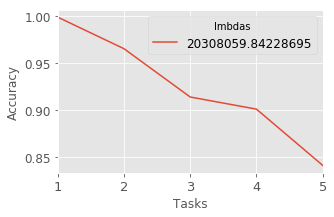

In [104]:
#fig, ax = plt.subplots(figsize=(4.5,2.5))
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df2.iloc[:,2:].plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

Text(0.5,0,'Tasks')

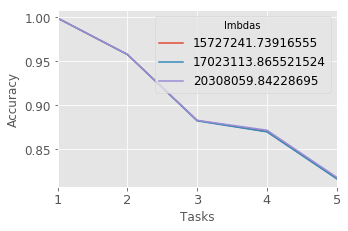

In [60]:
mpl.rcParams['figure.figsize'] = 5,3.25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df3.plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

In [105]:
Min = df1.iloc[:,2:].values[:,0]
Max = df2.iloc[:,2:].values[:,0]
Mean = df3.iloc[:,2:].values[:,0]
final_df = pd.DataFrame({'Min':Mini, 'Max':Maxi, 'Mean':Mean})
final_df

,Max,Mean,Min
0,0.999054,0.998913,0.998582
1,0.965119,0.957662,0.945874
2,0.913945,0.882806,0.859725
3,0.898840,0.871623,0.828240
4,0.840600,0.818160,0.781000


In [106]:
final_df.index.rename('Task', inplace=True)
final_df

,Max,Mean,Min
Task,,,
0,0.999054,0.998913,0.998582
1,0.965119,0.957662,0.945874
2,0.913945,0.882806,0.859725
3,0.898840,0.871623,0.828240
4,0.840600,0.818160,0.781000


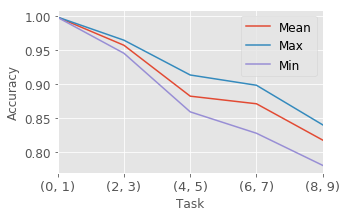

In [119]:
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax = final_df.plot(y=['Mean','Max','Min'],x=final_df.index)
ax.set_xticklabels([str((0,1)), str((2,3)), str((4,5)), str((6,7)), str((8,9))])
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.pdf', bbox_inches='tight')
plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.png', bbox_inches='tight')
plt.savefig('../outputs/tg_mnist_results_cl/disjoint_accuracy.eps', bbox_inches='tight')
plt.show()

# Init the writer with  best $\lambda$s and train $10\%$ of previous samples

In [10]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_mnist_ar1_final_5pc', sess.graph)

# Generate $\lambda$s 

In [11]:
np.random.seed(100)
n_lmbdas = 6
a = np.random.uniform(low=111.0, high=220, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e5
a = a[np.argsort(a)].tolist()
a= a[-1:]
a = a+[1.5*a[0]]
print(a)
print()
n_reps = 10
#a = ([0]+a.tolist())*n_reps
#n_lmbdas+=1
a = a*n_reps
print(a, len(a))

[170.23113866 141.34226298 157.27241739 203.08059842 111.51435532
 124.25103417]
()
[20308059.84228695, 30462089.763430428]
()
([20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428, 20308059.84228695, 30462089.763430428], 20)


# Generate random weights 

In [12]:
lmbdas = a
np.random.seed(0)
np_weights = []
n_lmbdas = 2
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(20, 20)


In [13]:
np.array_equal(np_weights[0], np_weights[1])

True

In [14]:
np.array_equal(np_weights[0], np_weights[2])

False

# Commence training

In [15]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
all_prev_task_test_accs = []
all_prev_task_test_activs = []
all_prev_task_test_accs_extra = []
all_prev_task_test_activs_extra = []
retrain_tes_acc = []
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    frac_old_train_images = []
    frac_old_train_labels = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    prev_task_test_accs = []
    prev_task_test_activs = []
    prev_task_test_accs_extra = []
    prev_task_test_activs_extra = []
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==epochs-1):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)
                if(i%2==0):
                    print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                if(i%2==0):
                    print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})
                if(i%2==0):
                    print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            if(i==epochs-1):   
                                summary,_,_ = sess.run([merged,step, omega_step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            else:
                                summary,_, = sess.run([merged,step], 
                                                     feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                                  set1_mask:set_mask_val,eta:0.001,
                                                                  lmbda:lmbdas[l],n_tot:train_total,
                                                                 gradient_gate:1})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            if(i==epochs-1):
                                sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                         tau:0.5,set1_mask:set_mask_val,
                                                                         eta:0.001,lmbda:lmbdas[l],
                                                                         n_tot:train_total,
                                                                        gradient_gate:1})
                            else:
                                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total,
                                                            gradient_gate:1})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
        
        old_test_data.append(test_data_set)
        frac_old_train_images.append(train_images_set[0:int(len(train_images_set[0])*0.1),:])
        frac_old_train_labels.append(train_labels_set[0:int(len(train_images_set[0])*0.1),:])
        #######Method 3 ###########
        w3_set_rows = []
        offset=0
        for item in w3_accum:
            w3_set_rows.append(item[:,offset:offset+2])
            offset+=2


        w3_set_row_avgs = [item.mean() for item in w3_set_rows]
        final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
        #final_w3 = np.concatenate(final_w3, axis=1)
        final_w3 = np.concatenate([item for item in final_w3]+[np.zeros((1500,10-offset))], axis=1)
        
        b3_set_rows = []
        offset=0
        for item in b3_accum:
            b3_set_rows.append(item[:,offset:offset+2])
            offset+=2
        b3_set_row_avgs = [item.mean() for item in b3_set_rows]
        final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
        #final_b3 = np.concatenate(final_b3, axis=1)
        final_b3 = np.concatenate([item for item in final_b3]+[np.zeros((1,10-offset))], axis=1)
        
        #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
        #@@sess.run(set_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
        sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs.append(final_test_acc)
            prev_task_test_activs.append(final_test_activ)
            print('Method 3 test accuracy:{}'.format(final_test_acc))
        
        print('Extra training..')
        enlarged_train_imgs = np.concatenate(frac_old_train_images, axis=0)
        enlarged_train_lbls = np.concatenate(frac_old_train_labels, axis=0)
        extra_X, extra_y = shuffle(enlarged_train_imgs, enlarged_train_lbls, random_state=0)
        #extra_X = extra_X.astype(np.float32)
        #extra_y = extra_y.astype(np.float32)
        for rep in range(5):
            sess.run(iter.initializer, feed_dict={a_1: extra_X, y: extra_y,
                                                      batch_size: BATCH_SIZE})
            enlarged_batches = len(enlarged_train_imgs)/BATCH_SIZE
            for j in range(enlarged_batches):
                if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):        
                    sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                             tau:0.5,set1_mask:set_mask_val,
                                                             eta:0.001,lmbda:0,
                                                             n_tot:train_total,
                                                            gradient_gate:1.0})
                else:
                    print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
        
        for items in old_test_data:
            test_images_set, test_labels_set = items[0], items[1]
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, 
                                                  y:test_labels_set,
                                                  batch_size: len(test_images_set)})
            _,final_test_acc,final_test_activ = sess.run([predictions, acct_res, a_3],
                                      feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
            prev_task_test_accs_extra.append(final_test_acc)
            prev_task_test_activs_extra.append(final_test_activ)
            print('Method 3 test accuracy after extra trai:{}'.format(final_test_acc))
        
        w3_accum[-1] = w_3.eval()
        b3_accum[-1] = b_3.eval()
    
    all_prev_task_test_accs.append(prev_task_test_accs)
    all_prev_task_test_activs.append(prev_task_test_activs)
    
    all_prev_task_test_accs_extra.append(prev_task_test_accs_extra)
    all_prev_task_test_activs_extra.append(prev_task_test_activs_extra)
    
    #sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
    #                                                      batch_size: len(test_images)})
    #_,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
    #                              feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    #method3_test_accs.append(final_test_acc)
    #print('Final test accuracy before extra training:{}'.format(final_test_acc))
    
    #print('5pc training after sequential training is done')
    
    #sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
    #                                                      batch_size: len(test_images)})
    #_,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
    #                              feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    #method3_test_accs.append(final_test_acc)
    #print('Final test accuracy after extra training:{}'.format(final_test_acc))
    #retrain_tes_acc.append(final_test_acc)
                        
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:20308059.8423, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0546306855977 and training accuracy:0.998178005219
validation cost:0.0556919276714 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0226408895105 and training accuracy:0.998785376549
validation cost:0.0242020450532 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147487148643 and training accuracy:0.998872101307
validation cost:0.016287503764 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0111239394173 and training accuracy:0.998872101307
validation cost:0.0125813987106 and validation 

Training on :(2, 3)
training cost:0.0984297245741 and training accuracy:0.976456701756
validation cost:0.105959877372 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0718252956867 and training accuracy:0.983183324337
validation cost:0.078507758677 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.0578409545124 and training accuracy:0.986274003983
validation cost:0.0634545683861 and validation accuracy:0.983455896378
Training on :(2, 3)
Time taken:139.516835213
Method 3 test accuracy:0.988652467728
Method 3 test accuracy:0.919196844101
Extra training..
Method 3 test accuracy after extra trai:0.977777779102
Method 3 test accuracy after extra trai:0.954946160316
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
vali

Time taken:133.73584795
Method 3 test accuracy:0.984397172928
Method 3 test accuracy:0.934378087521
Method 3 test accuracy:0.578975439072
Extra training..
Method 3 test accuracy after extra trai:0.979196190834
Method 3 test accuracy after extra trai:0.933888316154
Method 3 test accuracy after extra trai:0.850053369999
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0932315289974 and training accuracy:0.994588255882
validation cost:0.0895357131958 and validation accuracy:0.994525551796
Training on :(6, 7)
training cost:0.0511328838766 and training accuracy:0.996933341026
validation cost:0.0488969236612 and validation accuracy:0.997262775898
Training on :(6, 7)
training c

Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.174566730857 and training accuracy:0.966008543968
validation cost:0.174082145095 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.118920505047 and training accuracy:0.973365604877
validation cost:0.118878796697 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.096406981349 and training accuracy:0.977742612362
validation cost:0.0963543206453 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0831161811948 and training accuracy:0.979791402817
validation cost:0.0829119607806 and validation accuracy:0.982109248638
Training on :(8, 9)
Time taken:136.458171844
Method 3 test accuracy:0.981087446213
Me

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.055508248508 and training accuracy:0.99809128046
validation cost:0.0561634711921 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0225540343672 and training accuracy:0.998698592186
validation cost:0.0237094499171 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0145592540503 and training accuracy:0.998785376549
validation cost:0.0157190151513 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0109200486913 and training accuracy:0.99895888567
validation cost:0.0120275393128 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:144.549359083
Method 3 test accuracy:0.999054372311
Extra training..
Method 3 test accuracy after extra trai:0.999054372311
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of 

Training on :(2, 3)
training cost:0.0568571351469 and training accuracy:0.986728489399
validation cost:0.0606752969325 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:137.771406889
Method 3 test accuracy:0.986288428307
Method 3 test accuracy:0.929970622063
Extra training..
Method 3 test accuracy after extra trai:0.978723406792
Method 3 test accuracy after extra trai:0.958374142647
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.133445546031 and training accuracy:0.989560961723
validation cost:0.13000664115 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0701068267226 and training accuracy:0.993951201439
validation cost:0.

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.100383169949 and training accuracy:0.995670616627
validation cost:0.0977528989315 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0551327988505 and training accuracy:0.997654914856
validation cost:0.0539576262236 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0399021245539 and training accuracy:0.998376488686
validation cost:0.0391245670617 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.031990006566 and training accuracy:0.998647093773
validation cost:0.0313815437257 and validation accuracy:1.0
Training on :(6, 7)
Time taken:139.194628
Method 3 test accuracy:0.979669034481
Method 3 test accuracy:0.911361396313
Method 3 test accuracy:0.827641427517
Method 3 test accuracy:0.850453197956
Extra training..
Method 3 test accuracy after extra trai:0.9721040

Training on :(8, 9)
training cost:0.109307430685 and training accuracy:0.974390029907
validation cost:0.109192200005 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0878904685378 and training accuracy:0.979418873787
validation cost:0.0876291617751 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0754620432854 and training accuracy:0.982305824757
validation cost:0.0749981403351 and validation accuracy:0.985875725746
Training on :(8, 9)
Time taken:134.642755985
Method 3 test accuracy:0.980141818523
Method 3 test accuracy:0.846718907356
Method 3 test accuracy:0.871398091316
Method 3 test accuracy:0.879657626152
Method 3 test accuracy:0.582450807095
Extra training..
Method 3 test accuracy after extra trai:0.967375874519
Method 3 test accuracy after extra trai:0.887855052948
Method 3 test accuracy after extra trai:0.827641427517
Method 3 test accuracy after extra trai:0.880664646626
Method 3 test accuracy after extra trai:0.834594070911
T

Training on :(0, 1)
training cost:0.014548827894 and training accuracy:0.998872101307
validation cost:0.0156352259219 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0109188891947 and training accuracy:0.99895888567
validation cost:0.0120074385777 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:144.764646053
Method 3 test accuracy:0.999054372311
Extra training..
Method 3 test accuracy after extra trai:0.999054372311
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172353744507 and training accuracy:0.962548851967
validation cost:0.176611214876 and validation accuracy:0.960477948189
Training on :(2, 3)
training cost:0.09569

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.136917114258 and training accuracy:0.99014633894
validation cost:0.134103387594 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0725125521421 and training accuracy:0.994341492653
validation cost:0.0665539875627 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0510011985898 and training accuracy:0.995804905891
validation cost:0.0446213856339 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0401034131646 and training accuracy:0.996097564697
validation cost:0.0338150151074 and validation accuracy:1.0
Training on :(4, 5)
Time taken:129.414355993
Method 3 test accuracy:0.983451545238
Method 3 test accuracy:0.945151805878
Method 3 test accuracy:0.595517635345
Extra training..
Method 3 test accuracy after extra trai:0.979669034481
Method 3 test accuracy after extra trai:0.941234111786
Method

Training on :(6, 7)
training cost:0.037259850651 and training accuracy:0.997925519943
validation cost:0.0357767157257 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0297109112144 and training accuracy:0.998376488686
validation cost:0.0283927787095 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:138.330507994
Method 3 test accuracy:0.984397172928
Method 3 test accuracy:0.90205681324
Method 3 test accuracy:0.799359679222
Method 3 test accuracy:0.879657626152
Extra training..
Method 3 test accuracy after extra trai:0.973995268345
Method 3 test accuracy after extra trai:0.918217420578
Method 3 test accuracy after extra trai:0.874599814415
Method 3 test accuracy after extra trai:0.926485419273
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and 

Training on :(8, 9)
Time taken:134.885094881
Method 3 test accuracy:0.983451545238
Method 3 test accuracy:0.885896205902
Method 3 test accuracy:0.787086427212
Method 3 test accuracy:0.863544821739
Method 3 test accuracy:0.643469512463
Extra training..
Method 3 test accuracy after extra trai:0.969267129898
Method 3 test accuracy after extra trai:0.895200788975
Method 3 test accuracy after extra trai:0.812166512012
Method 3 test accuracy after extra trai:0.873615324497
Method 3 test accuracy after extra trai:0.839636921883
Training with lmbda:20308059.8423, 14
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.054135248065 and training accuracy:0.998004

Method 3 test accuracy after extra trai:0.998581588268
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.175582334399 and training accuracy:0.963094234467
validation cost:0.180952474475 and validation accuracy:0.960477948189
Training on :(2, 3)
training cost:0.0985320657492 and training accuracy:0.976365804672
validation cost:0.10442866385 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0725395828485 and training accuracy:0.982547044754
validation cost:0.0777347907424 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0587511844933 and training accuracy:0.986274003983
validation cost:0.0630826354027 and validation accurac

Training on :(4, 5)
training cost:0.069614879787 and training accuracy:0.994731724262
validation cost:0.0633565485477 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0487425997853 and training accuracy:0.99590241909
validation cost:0.0421532355249 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0381969548762 and training accuracy:0.996487796307
validation cost:0.0317724309862 and validation accuracy:1.0
Training on :(4, 5)
Time taken:128.847719908
Method 3 test accuracy:0.986761212349
Method 3 test accuracy:0.931439757347
Method 3 test accuracy:0.595517635345
Extra training..
Method 3 test accuracy after extra trai:0.979669034481
Method 3 test accuracy after extra trai:0.937806069851
Method 3 test accuracy after extra trai:0.848986148834
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:

Training on :(6, 7)
Time taken:138.830854177
Method 3 test accuracy:0.98486995697
Method 3 test accuracy:0.908912837505
Method 3 test accuracy:0.696371376514
Method 3 test accuracy:0.885699927807
Extra training..
Method 3 test accuracy after extra trai:0.973522484303
Method 3 test accuracy after extra trai:0.921155750751
Method 3 test accuracy after extra trai:0.854322314262
Method 3 test accuracy after extra trai:0.92245721817
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.175193324685 and training accuracy:0.963587284088
validation cost:0.173799276352 and validation accuracy:0.96233522892
Training on :(8, 9)
training cost:0.119612805545 and training accuracy:0.971968

Method 3 test accuracy after extra trai:0.837115466595
Training with lmbda:30462089.7634, 19
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0543369539082 and training accuracy:0.997570693493
validation cost:0.0553945638239 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0226058047265 and training accuracy:0.997917771339
validation cost:0.0243187975138 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147604439408 and training accuracy:0.998525083065
validation cost:0.0164875015616 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0111444368958 and training accuracy:0.998

# Final accuracy

In [19]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)

indices = [[0,1], [1,3], [3,6], [6,10], [10,15]]

np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)

sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]
sum_scaled = np.array(sum_scaled).reshape(20,5)

In [21]:
all_test_samples = []
for i in range(len(n_test_samples)+1):
    all_test_samples.extend(n_test_samples[0:i])
all_test_samples = [np.array(all_test_samples)]*len(all_prev_task_test_accs)

indices = [[0,1], [1,3], [3,6], [6,10], [10,15]]

np_all_test_accs = [np.array(item) for item in all_prev_task_test_accs_extra]
scaled_all_accs = map(lambda x,y: x*y, all_test_samples, np_all_test_accs)

sum_scaled = [thing[item[0]:item[1]].sum()/all_test_samples[0][item[0]:item[1]].sum() for thing in scaled_all_accs for item in indices]
sum_scaled = np.array(sum_scaled).reshape(20,5)

In [22]:
sum_scaled

array([[0.99905437, 0.96704355, 0.92124025, 0.91917176, 0.8781    ],
       [0.99905437, 0.96656244, 0.92074283, 0.91742548, 0.87639999],
       [0.99905437, 0.97089246, 0.92372739, 0.92129226, 0.8789    ],
       [0.99905437, 0.97017078, 0.92339578, 0.91979543, 0.8771    ],
       [0.99905437, 0.9677652 , 0.92472228, 0.92328802, 0.8794    ],
       [0.99905437, 0.96752466, 0.92488808, 0.9231633 , 0.87739999],
       [0.99905437, 0.96872745, 0.92505388, 0.9192965 , 0.8826    ],
       [0.99905437, 0.96920857, 0.9253855 , 0.9192965 , 0.88010001],
       [0.99905437, 0.96752465, 0.9283701 , 0.92191594, 0.88140001],
       [0.99905437, 0.96800576, 0.92903335, 0.9217912 , 0.88000001],
       [0.99905437, 0.97041133, 0.92521969, 0.92154172, 0.8808    ],
       [0.99905437, 0.97041133, 0.92289837, 0.91804915, 0.87610002],
       [0.99905437, 0.96993025, 0.9268778 , 0.92478484, 0.88249999],
       [0.99905437, 0.96968969, 0.92837008, 0.92341276, 0.88000001],
       [0.99858159, 0.96800576, 0.

In [24]:
index = pd.MultiIndex.from_arrays([lmbdas], names=['lmbdas'])
df = pd.DataFrame(columns = [i for i in range(1,6)], data=sum_scaled, index=index)
df.to_csv('spike_mnist_ar1_final_10pc.csv')
df.head()

,1,2,3,4,5
lmbdas,,,,,
2.030806e+07,0.999054,0.967044,0.921240,0.919172,0.8781
3.046209e+07,0.999054,0.966562,0.920743,0.917425,0.8764
2.030806e+07,0.999054,0.970892,0.923727,0.921292,0.8789
3.046209e+07,0.999054,0.970171,0.923396,0.919795,0.8771
2.030806e+07,0.999054,0.967765,0.924722,0.923288,0.8794


## Plots

In [25]:
group_by_lmbda = df.groupby(level=['lmbdas'])
df1 = group_by_lmbda.min().T
display(df1)
df2 = group_by_lmbda.max().T
display(df2)
df3 = group_by_lmbda.mean().T
display(df3)
df4 = group_by_lmbda.median().T
display(df4)
df5 = group_by_lmbda.std().T
display(df5)

lmbdas,20308059.84228695,30462089.763430428
1,0.998109,0.998109
2,0.967044,0.966562
3,0.921240,0.920743
4,0.919172,0.917425
5,0.878100,0.876100


lmbdas,20308059.84228695,30462089.763430428
1,0.999054,0.999054
2,0.970892,0.970411
3,0.928370,0.929033
4,0.924785,0.923413
5,0.882600,0.880100


lmbdas,20308059.84228695,30462089.763430428
1,0.998865,0.998865
2,0.968944,0.968896
3,0.924838,0.924739
4,0.921517,0.920369
5,0.880410,0.877880


lmbdas,20308059.84228695,30462089.763430428
1,0.999054,0.999054
2,0.968968,0.969209
3,0.924971,0.924556
4,0.921417,0.919733
5,0.880500,0.877250


lmbdas,20308059.84228695,30462089.763430428
1,0.000331,0.000331
2,0.001329,0.001303
3,0.002056,0.002529
4,0.001746,0.002141
5,0.001534,0.001627


Text(0.5,0,'Tasks')

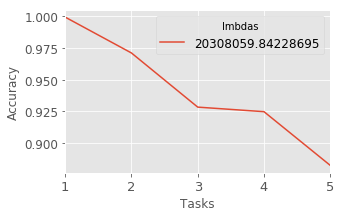

In [26]:
#fig, ax = plt.subplots(figsize=(4.5,2.5))
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df2.iloc[:,0:1].plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

Text(0.5,0,'Tasks')

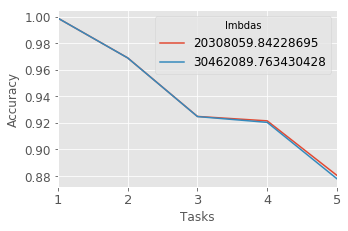

In [27]:
mpl.rcParams['figure.figsize'] = 5,3.25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
df3.plot()
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.xlabel('Tasks')

In [30]:
Min = df1.iloc[:,0:1].values[:,0]
Max = df2.iloc[:,0:1].values[:,0]
Mean = df3.iloc[:,0:1].values[:,0]
final_df = pd.DataFrame({'Min':Min, 'Max':Max, 'Mean':Mean})
final_df

,Max,Mean,Min
0,0.999054,0.998865,0.998109
1,0.970892,0.968944,0.967044
2,0.928370,0.924838,0.921240
3,0.924785,0.921517,0.919172
4,0.882600,0.880410,0.878100


In [31]:
final_df.index.rename('Task', inplace=True)
final_df

,Max,Mean,Min
Task,,,
0,0.999054,0.998865,0.998109
1,0.970892,0.968944,0.967044
2,0.928370,0.924838,0.921240
3,0.924785,0.921517,0.919172
4,0.882600,0.880410,0.878100


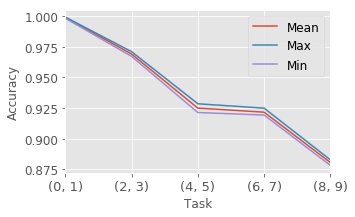

In [32]:
mpl.rcParams['figure.figsize'] = 4.75,3.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
ax = final_df.plot(y=['Mean','Max','Min'],x=final_df.index)
ax.set_xticklabels([str((0,1)), str((2,3)), str((4,5)), str((6,7)), str((8,9))])
ax.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
ax.set_ylabel('Accuracy')
plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.pdf', bbox_inches='tight')
plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.png', bbox_inches='tight')
plt.savefig('../outputs/tg_mnist_results_cl/buffered_accuracy.eps', bbox_inches='tight')
plt.show()